**Get Data and Visualize**

In [1]:
import pandas as pd

df = pd.read_csv('Data_Households_SmartPV.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

weekday_df = df[df['Timestamp'].dt.dayofweek < 5]
weekday_avg = weekday_df.groupby([weekday_df['Timestamp'].dt.hour, weekday_df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-15 00:00:00', end='2016-06-15 23:30:00', freq='30min')
weekday_avg['Timestamp'] = timestamps
weekday_avg.set_index('Timestamp', inplace=True)
weekday_avg = weekday_avg / 1000  # Convert to kWh
weekday_avg.head()




,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-06-15 00:00:00,0.614941,0.845336,0.0,0.586632,0.0,0.845336,0.845336
2016-06-15 00:30:00,0.614931,0.789306,0.0,0.586633,0.0,0.789306,0.789306
2016-06-15 01:00:00,0.614941,0.747229,0.0,0.586632,0.0,0.747229,0.747229
2016-06-15 01:30:00,0.614931,0.720732,0.0,0.586633,0.0,0.720732,0.720732
2016-06-15 02:00:00,0.614941,0.688052,0.0,0.586632,0.0,0.688052,0.688052


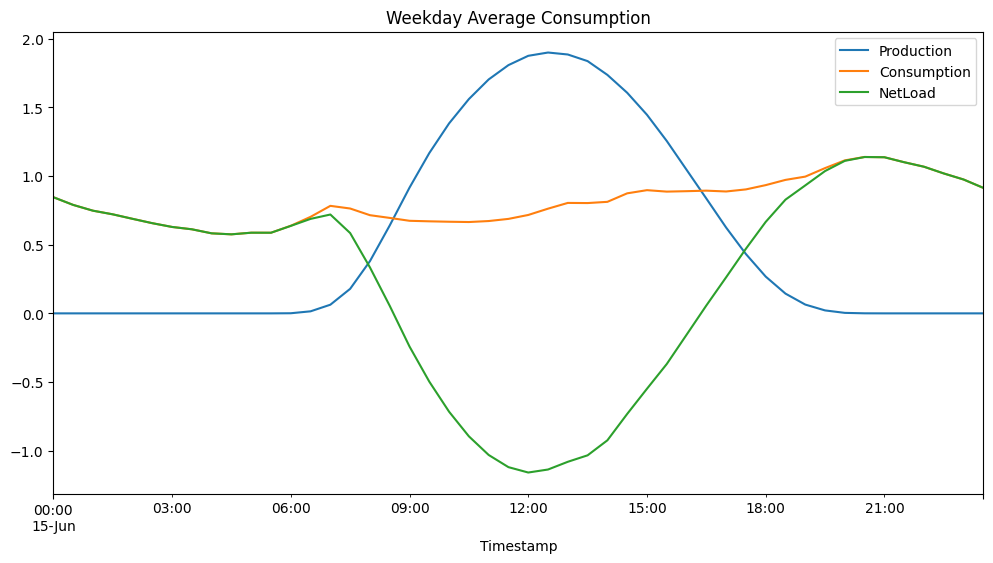

In [2]:
import matplotlib.pyplot as plt
_ = weekday_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Weekday Average Consumption', figsize=(12, 6))

**Battery Control**

This optimization is the basic scenario of controlling the battery for a day. Primarily, this is meant to test functionality of the optimization before scaling to more complicated pricing schemes. 

The maximum number of function evaluations is exceeded.
Number of iterations: 4000, function evaluations: 195951, CG iterations: 18193, optimality: 5.35e-02, constraint violation: 0.00e+00, execution time: 3.4e+01 s.


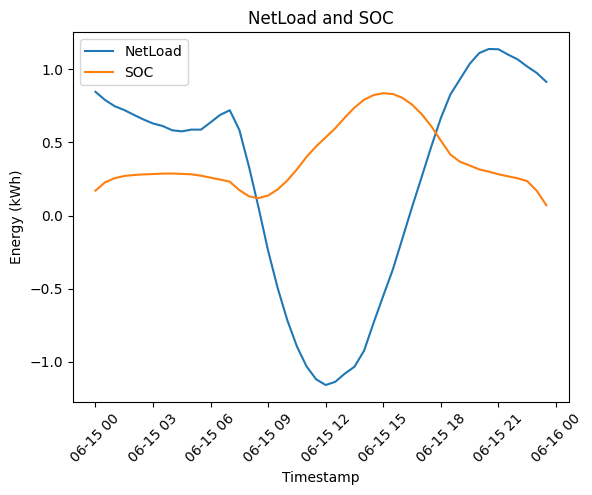

In [13]:
from charge_optimizer import ChargeOptimizer
import numpy as np

BATT_PRICE_PER_KWH = 127  # Euros per kWh (127 is what was found online)
max_charge_rate = 0.5  # Max charge rate in % per hour
max_discharge_rate = 0.5  # Max discharge rate in % per hour
soc_min = 0.05  # Maximum Depth of Discharge 95%
soc_max = 1.00  # Maximum State of Charge 100%; can play around with to protect battery
sqrt_eff = 0.98  # round trip Efficiency of the battery
self_discharge = 0.05  # 5% self discharge per day; totally made up
batt_life = 10 # years; totally made up
import_tariff = np.full(24, 0.37) # Single price tariff; 0.37 Euros per kWh


charge_optimizer = ChargeOptimizer(
    pred_net_load=weekday_avg['NetLoad'],
    duration=1,
    import_tariff=import_tariff,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5, # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
    batt_capacity=10,  # 13.5 kWh
)

charge_optimizer.local_optimize(method='SLSQP')
charge_optimizer.plot_results(weekday_avg.index)

**Optimization of Battery Size for Net Savings**

This optimization accounts for the price of batteries and finds the optimal battery size to save consumers money (for the specified sample of 3kW systems). This exists for both TOU tariffs and single-price tariffs. 

Information: https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
https://natec.com/wp-content/uploads/2020/12/6020-0205-Datasheet-LG-Chem-RESU-10H-High-Voltage-400V-type-C-for-SMA.pdf

**Single Price Tariff Optimization**

Although Cyprus uses Net-Metering, this study examines export energy that does not recieve remuneration

*Local Minimization* 

This code examines local minimization of the basic problem using SciPy minimize with SLSQP method.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.259092378912946
            Iterations: 140
            Function evaluations: 7287
            Gradient evaluations: 140
Battery Size: 8.493252828425808 kWh
Objective Function Final Value: 7.259092378912946


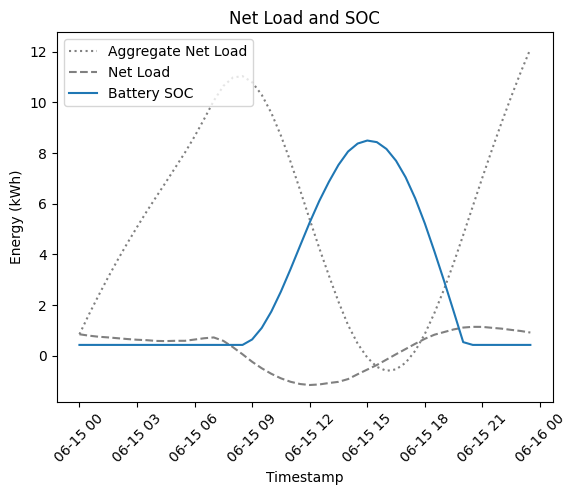

In [4]:
from price_optimizer import PriceOptimizer

price_optimizer = PriceOptimizer(
    pred_net_load=weekday_avg["NetLoad"],
    duration=1,
    batt_price_per_kWh=BATT_PRICE_PER_KWH,
    import_tariff=import_tariff,
    batt_life=batt_life,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5,  # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
)

price_optimizer.local_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)


*Global Minimization*

This code examines the same, simple problem above. However, here we use global minimization with differential evolution. The results are somewhat surprising upon first examination; global minimization should outperform local minimization if correctly done. However, given that the initial guess provided to local minimization makes strong inuitive sense given the problem at hand, we can imagine that the local minimization is better equipped to more quickly hone in on the optimal spread. However, future work could be done to refine the globalization model (such as different strategies and searching time) that could/should result in results as good as the local minimization.  

Battery Size: 2.1128210528549722 kWh
Objective Function Final Value: 8.768694120734727


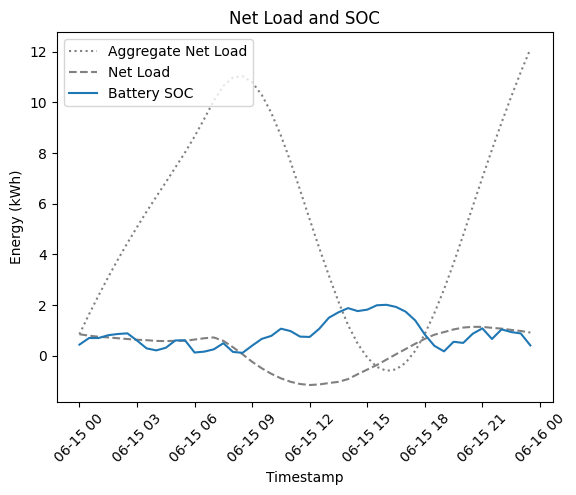

In [5]:
price_optimizer.batt_ub = 10 # Close bounds for global optimization
price_optimizer.batt_lb = 2
price_optimizer.global_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

*Bi-Level Optimization*

This optimization method uses a two-tiered approach. The first, or "inner", optimization works to minimize an objective function pertaining to only the charge control. The outer optimization takes the inner optimization as an objective function and works to optimize the capacity of the battery for cost-savings. This approach should have to advantages: The first is to simply a complex optimization problem into two very simple problems. Both charge control and battery size are simple problems by themselves – as such, this optimization should take advantage of the easy nature of the decomposed problem. The second is to place an emphasis on battery capacity. In the above optimizations, the battery size is just another input variable like any of the timepoints. In larger and larger duration optimizations this will become problematic because battery size is an extremely important input. Yet to have it be one of tens of thousands of inputs will overcomplicate the model; thus, this approach more naturally addresses the structure of the problem. 

In the first cell we visualize this phenomenon by plotting the output of the charge minimization with respect to x. This allows us to visualize how the minimization works. 

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


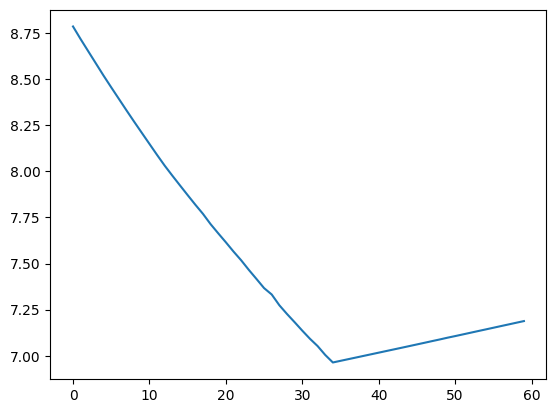

In [9]:

price_optimizer.batt_ub = 100 # Open bounds for other optimization
price_optimizer.batt_lb = 0

objective_vals = []

for i in range(0, 60):
    charge_optimizer.set_batt_capacity(i / 4.0)
    charge_optimizer.local_optimize(method='SLSQP', disp=False, tol=1e-6)
    objective_vals.append(float(charge_optimizer.result.fun))
    print(f'Iteration: {i}')

plt.plot(range(0, 60), objective_vals)


/Users/alextseng/MacDocuments/foss-optimization/price_optimizer.py:112: RuntimeWarning: Method BFGS cannot handle bounds.
  result = spo.minimize(


Iteration of battery capacity: 2.0. Objective value: 8.33784147116698
Iteration of battery capacity: 4.0. Objective value: 7.957367138181565
Iteration of battery capacity: 2.1902371664927074. Objective value: 8.298682469343241
Iteration of battery capacity: 4.190237166492707. Objective value: 7.924147140855498
Iteration of battery capacity: 2.951185832463537. Objective value: 8.143779381918291
Iteration of battery capacity: 4.951185832463537. Objective value: 7.796075326427307
Iteration of battery capacity: 5.994980496346855. Objective value: 7.625798194989664
Iteration of battery capacity: 7.994980496346855. Objective value: 7.327594022368837
Iteration of battery capacity: 15.641575346024174. Objective value: 7.764583140803746
Iteration of battery capacity: 17.641575346024176. Objective value: 7.9067009870456335
Iteration of battery capacity: 9.345225970118156. Objective value: 7.318971684119544
Iteration of battery capacity: 11.345225970118156. Objective value: 7.459804892263853
Iter

/Users/alextseng/MacDocuments/foss-optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Battery Size: 8.270543405913974 kWh
Objective Function Final Value: 7.000961120040785


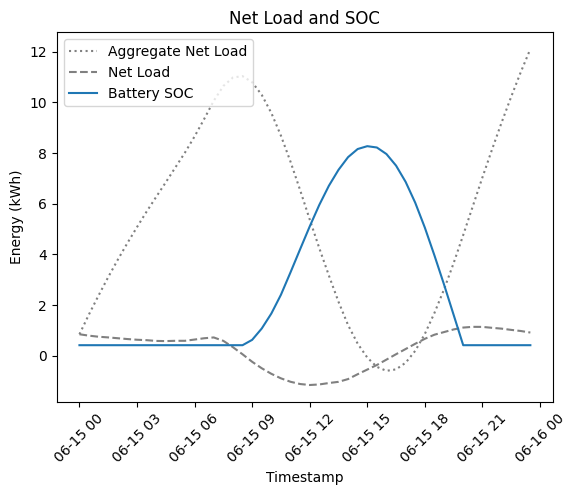

In [10]:
price_optimizer.bilevel_optimize(method='BFGS')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

**Average Week Optimization**

Up to this point, we have explored an average day. Although this allows us to visually and intuitively check the correctness of optimization, it is also fairly trivial and provides little meaningful information. Here we scale the optimization to an average week, month, and year. 

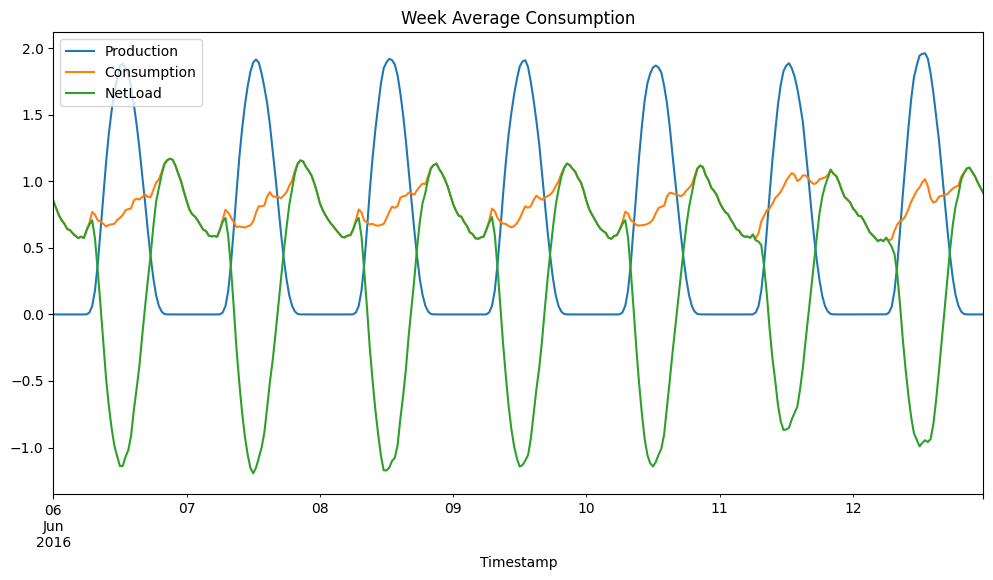

In [5]:
week_avg = df.groupby([df['Timestamp'].dt.day_of_week, df['Timestamp'].dt.hour, df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-06 00:00:00', end='2016-06-12 23:30:00', freq='30min')
week_avg['Timestamp'] = timestamps
week_avg.set_index('Timestamp', inplace=True)
week_avg.index = pd.to_datetime(week_avg.index)
week_avg = week_avg / 1000  # Convert to kWh

week_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Week Average Consumption', figsize=(12, 6))
plt.show()

*Charge Optimization*

Models   |  Function Value  |  Time
SLSQP    |  49.26408798     |  4m 43.8s
L-BFGS-B |  Cannot Handle Constraints 

In [14]:
charge_optimizer.duration = 7
charge_optimizer.set_new_input(week_avg['NetLoad'], 7, import_tariff)
print(f'Optimizing for {charge_optimizer.duration} days')
charge_optimizer.local_optimize(method='trust-constr', tol=1e-6)
charge_optimizer.plot_results(week_avg.index)

Optimizing for 7 days


KeyboardInterrupt: 